In [1]:
import os
import numpy as np
import torch
import random
import parmed
import nglview as ng
import MDAnalysis as md
from MDAnalysis.analysis import dihedrals
import matplotlib.pyplot as plt

import mymd

In [2]:
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
data_path = '../../data/md_from_scratch/'
csv_path = '../tmp/'
dcd_path = '../tmp/'
dt_fs = 2

# ala15 in openmm
old_pdb_file = os.path.join(data_path, 'ala15.pdb')
pdb_file = os.path.join(data_path, 'ala15_new.pdb')
psf_file = os.path.join(data_path, 'ala15.psf')
prmtop_file = os.path.join(data_path, 'ala15.prmtop')
coor_file = None
xsc_file = None
cutoff = None
T = 300.15
dcd_interval = 100
steps = 50000
min_energy_max_iter = 100
box_size = 100  # can not be too small, e.g. 20 do not work

# structure: prod_alanine_dipeptide_amber
# prmtop_file = os.path.join(data_path, 'structure.prmtop')
# coor_file = os.path.join(data_path, 'input.coor')
# xsc_file = os.path.join(data_path, 'input.xsc')
# psf_file = None
# pdb_file = None
# cutoff = 9
# T = 300
# dcd_interval = 10
# steps = 500
# min_energy_max_iter = 100

In [4]:
# for ala15 in openmm
# mymd.gen_files_from_pdb(old_pdb_file=old_pdb_file,
#                         psf_file=psf_file,
#                         prmtop_file=prmtop_file,
#                         new_pdb_file=pdb_file)

In [5]:
mol = mymd.get_molecule(prmtop_file=prmtop_file, pdb_file=pdb_file, coor_file=coor_file, xsc_file=xsc_file)
print('---coords---')
print(mol.coords[:2])
print('-----box-----')
print(mol.box)
print('---charge---')
print(mol.charge[:3])
print('---masses---')
print(mol.masses[:3])
print('----bonds----')
print(mol.bonds[:4])
print('---bonds.shape---')
print(mol.bonds.shape)

2023-05-11 10:19:57,431 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


---coords---
[[[ 3.326]
  [ 1.548]
  [-0.   ]]

 [[ 4.046]
  [ 0.84 ]
  [-0.   ]]]
-----box-----
[[0.]
 [0.]
 [0.]]
---charge---
[0.1414 0.1997 0.1997]
---masses---
[14.00672   1.007947  1.007947]
----bonds----
[[4 5]
 [6 7]
 [6 8]
 [6 9]]
---bonds.shape---
(152, 2)


In [6]:
try:
    ff = mymd.PrmtopMolForceField(mol, prmtop_file, allow_unequal_duplicates=False)
except:
    print('False causes error, use True.')
    ff = mymd.PrmtopMolForceField(mol, prmtop_file, allow_unequal_duplicates=True)

print(ff.mol.atomtype[:10])
print(ff.mol.charge[:10])  # same atomtype can have different charge ('C1') in ala15 in openmm
print(set(ff.mol.atomtype))
print(set(ff.params.atom_types))

False causes error, use True.
['N1' 'H1' 'H1' 'H1' 'C1' 'H2' 'C1' 'H3' 'H3' 'H3']
[ 0.1414  0.1997  0.1997  0.1997  0.0962  0.0889 -0.0597  0.03    0.03
  0.03  ]
{'C2', 'C1', 'H2', 'N1', 'H4', 'O1', 'H1', 'H3'}
{'C2', 'C1', 'H2', 'N1', 'H4', 'O1', 'H1', 'H3'}


In [7]:
system = mymd.System(mol, ff, cutoff=cutoff)
if psf_file is not None:
    # ala15
    system.set_periodic_box_manual(np.array([box_size, box_size, box_size]).reshape(3, 1))
print(system.bond_params[:5])
print(system.improper_params[0]['params'][:5])
print(system.uni_atom_types == np.unique(mol.atomtype))
print(system.uni_atom_types[system.mapped_atom_types[:6]] == mol.atomtype[:6])
print(system.box, mol.box)
print(system.cutoff)
print(system.external)
print(np.array(system.get_exclusions(types=['bonds']))[:3])
print(np.all(np.vstack((np.array(system.bonds), np.array(system.angles[:, [0, 2]]))) == np.array(system.get_exclusions(types=['bonds', 'angles']))))

tensor([[434.0000,   1.0100],
        [434.0000,   1.0100],
        [434.0000,   1.0100],
        [367.0000,   1.4710],
        [340.0000,   1.0900]])
tensor([[10.5000,  3.1416,  2.0000],
        [ 1.1000,  3.1416,  2.0000],
        [10.5000,  3.1416,  2.0000],
        [ 1.1000,  3.1416,  2.0000],
        [10.5000,  3.1416,  2.0000]])
[ True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True]
tensor([100, 100, 100]) [[0.]
 [0.]
 [0.]]
None
None
[[0 1]
 [0 2]
 [0 3]]
True


In [8]:
integrator = mymd.VelocityVerletIntegrator(dt_fs)
print(integrator.dt, integrator.dt_fs)

0.04090965899549196 2


In [9]:
simulation = mymd.Simulation(mol, system, integrator, 'cpu', torch.float)
simulation.set_positions(mol.coords)
simulation.set_velocities_to_temperature(T=T)
simulation.update_potentials_and_forces()

csv_reporter = mymd.CSVReporter(csv_path, 1)
simulation.add_reporter(csv_reporter)

print(torch.abs(simulation.vel).mean())
print(simulation.forces.shape)
print(simulation.forces[:5])
print(simulation.forces[-3:])
print(simulation.potentials)
print(simulation.potentials_sum)

Remove the original csv file.
tensor(0.3993)
torch.Size([153, 3])
tensor([[  6.9732,  -0.3641,  -2.7632],
        [  2.6895,  -4.3001,   0.1842],
        [-13.9122,  -9.6849,   8.2776],
        [-13.6734,  -9.2669,  -7.9898],
        [ 14.9448,  17.1064,   3.2955]])
tensor([[ 43.5949,   1.8483, -11.5043],
        [ -3.8238, -12.0503,  -0.0770],
        [ -7.4217,   7.7774,  -3.1221]])
{'bonds': 2.678370475769043, 'angles': 22.301218032836914, 'dihedrals': 114.44686889648438, 'impropers': 0.0, 'lj': 133.90985107421875, 'electrostatics': 205.76014709472656}
479.09645557403564


In [10]:
print(simulation.pos[:5])
simulation.minimize_energy(min_energy_max_iter)
print(simulation.pos[:5])
print(simulation.forces[:5])
print(simulation.potentials)
print(simulation.potentials_sum)

tensor([[ 3.3260,  1.5480, -0.0000],
        [ 4.0460,  0.8400, -0.0000],
        [ 2.8230,  1.5000, -0.8750],
        [ 2.8230,  1.5000,  0.8750],
        [ 3.9700,  2.8460, -0.0000]])
num_fun_eval	E_pot    	norm_F_max	rms      	max_abs_f_1d
     0      	479.096456	61.219425	12.796298	58.670746
     1      	1190.801353	501.836630	96.684789	480.253967
     2      	459.773098	32.192961	7.469886	31.148647
     3      	451.183983	20.136731	6.126632	15.518658
     4      	422.591838	26.790928	6.002363	25.174839
     5      	410.263694	35.369729	9.517760	32.013763
     6      	399.536301	16.971471	4.112849	15.793540
     7      	395.130934	14.789280	3.962099	13.693330
     8      	383.513289	23.959368	4.222301	23.861177
     9      	389.111876	120.437953	14.270097	102.365448
     10     	380.068186	39.721246	5.374799	37.130669
     11     	375.555071	25.226465	3.605046	21.634840
     12     	369.711062	10.205680	2.804824	8.739100
     13     	366.445753	44.420729	4.409495	40.467106
     14 

In [11]:
simulation.step(steps, dcd_path, dcd_interval)

100%|██████████| 50000/50000 [08:52<00:00, 93.95it/s]


In [12]:
if psf_file is not None:
    u = md.Universe(psf_file, os.path.join(dcd_path, 'traj.dcd'))
else:
    u = md.Universe(prmtop_file, os.path.join(dcd_path, 'traj.dcd'))

ng.show_mdanalysis(u, gui=True)

2023-05-11 10:28:50,422 - MDAnalysis.topology.PSF - WARNING - Guessing that this is actually a NAMD-type PSF file... continuing with fingers crossed!


NGLWidget(max_frame=500)

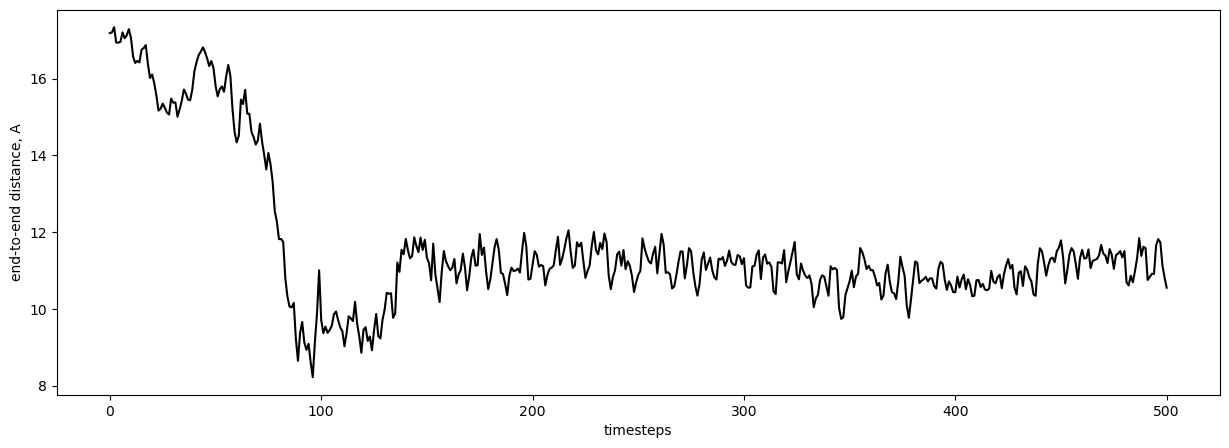

In [13]:
if psf_file is not None:
    # ala15
    N_terminus = u.select_atoms('resid 1 and name N')
    C_terminus = u.select_atoms('resid 5 and name C')

    # go through the whole trajectory and compute distance between them for every frame
    dist = []
    for frame in u.trajectory:
        dist.append(np.linalg.norm(N_terminus.positions - C_terminus.positions))

    # the result is in the dist array    
    dist = np.array(dist)
    plt.figure(figsize=(15,5))

    plt.plot(dist, '-k' )
    plt.xlabel('timesteps')
    plt.ylabel('end-to-end distance, A')

    plt.show()

/Users/jerrykwan/anaconda3/envs/temp/lib/python3.9/site-packages/MDAnalysis/analysis/dihedrals.py:422: UserWarning: Cannot determine phi and psi angles for the first or last residues
  warnings.warn("Cannot determine phi and psi angles for the first "
2023-05-11 10:28:50,892 - MDAnalysis.analysis.base - INFO - Choosing frames to analyze
2023-05-11 10:28:50,892 - MDAnalysis.analysis.base - INFO - Starting preparation
2023-05-11 10:28:50,902 - MDAnalysis.analysis.base - INFO - Finishing up
2023-05-11 10:28:50,905 - MDAnalysis.analysis.base - INFO - Choosing frames to analyze
2023-05-11 10:28:50,905 - MDAnalysis.analysis.base - INFO - Starting preparation
2023-05-11 10:28:50,914 - MDAnalysis.analysis.base - INFO - Finishing up
2023-05-11 10:28:50,916 - MDAnalysis.analysis.base - INFO - Choosing frames to analyze
2023-05-11 10:28:50,916 - MDAnalysis.analysis.base - INFO - Starting preparation
2023-05-11 10:28:50,926 - MDAnalysis.analysis.base - INFO - Finishing up


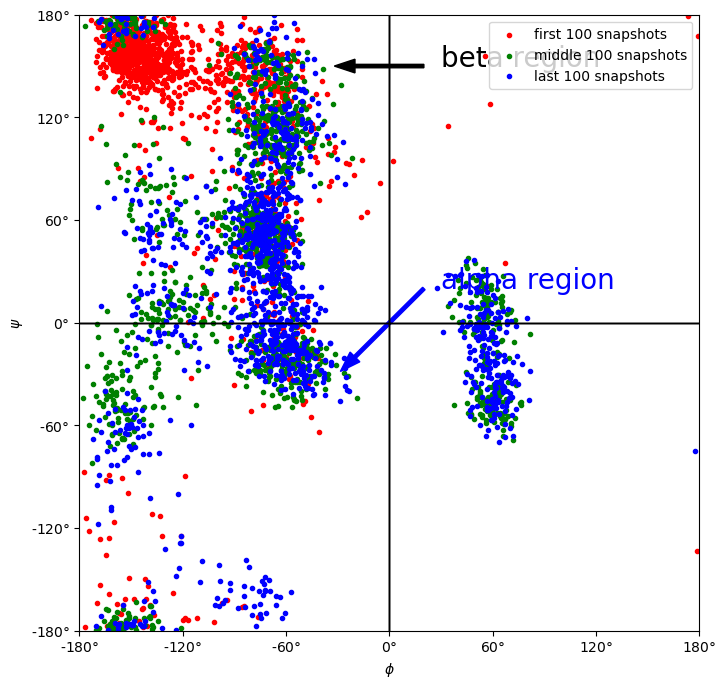

In [14]:
if psf_file is not None:
    # ala15
    ram1 = dihedrals.Ramachandran(u).run(0, 100) 
    ram_mid = dihedrals.Ramachandran(u).run(200, 300)
    ram2 = dihedrals.Ramachandran(u).run(400, 500)  # maybe not include the last snapshot

    # ramachandran plot
    fig, ax = plt.subplots(figsize=(8,8))
    ram1.plot(ax=ax, color='r', marker='.', label='first 100 snapshots')
    ram_mid.plot(ax=ax, color='g', marker='.', label='middle 100 snapshots')
    ram2.plot(ax=ax, color='b', marker='.', label='last 100 snapshots')
    ax.arrow(20, 20, -40, -40, width=2, head_width=8, head_length=12, fc='b', ec='b')
    ax.text(30, 20, 'alpha region', color='blue', fontsize=20)
    ax.arrow(20, 150, -40, 0, width=2, head_width=8, head_length=12, fc='k', ec='k')
    ax.text(30, 150, 'beta region', fontsize=20)
    plt.legend()
    plt.show()